# <center> Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations
    M.Raissi, P.Perdikaris, G.E.Karniadakis

In this presentation, we will delve into the realm of physics-informed neural networks (PINNs) by exploring relevant research papers, developing a comprehensive understanding, and coding the corresponding implementations. PINNs serve as universal approximators, enabling the approximation of functions, solutions to ordinary and partial differential equations (ODEs and PDEs), while adhering to the constraints imposed by the laws of physics within the loss functions. In scientific machine learning, various types of PINNs have been developed to tackle diverse problems. These include PINNs for both forward and inverse problems, conservative physics-informed neural networks designed for discrete domains, and shallow neural networks adept at capturing discontinuities in elliptic interface problems. During this presentation, we will meticulously examine papers in each category and demonstrate their practical implementation in TensorFlow and PyTorch. To foster a comprehensive understanding, we will begin by applying PINN methodologies to approximate any given functions.

### Approximate a function 

To approximate a given function, such as $y = x^3 + x^2 + x + 1$ within the interval $x \in (-5, 5)$, we gather a sufficient number of data points, denoted as $N$. Using a neural network architecture with $n$ layers, we employ the formulation $y_n = W^{[n]}(...\sigma(W^{[n-1]}x + b^{[n-1]}))+b^{[n]}$ to approximate $y \approx y_n$. To determine the neural network parameters, we define the loss function as:
$$Loss(\theta) = \frac{1}{M}\sum_{i=1}^{M}\big(y(x^{i})-y_n(x^i,\theta)\big)$$
In the following we implement the training and test by pytorch:

In [15]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs  # Latin Hypercube Sampling
import scipy.io

# Set default dtype to float32
torch.set_default_dtype(torch.float)

# PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

iters = 20000
lr = 1e-3
x_l = -5
x_r = 5
No_points = 2500


def f(x):
    y = x ** 3 + x ** 2 + x + 1
    return y


class FPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()  # Call __init__ from parent class

        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
#         self.iter = 0

        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
            
        a = x.float()
        for i in range(len(layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    def lossPINN(self, x, y):
        loss_val = self.loss_function(self.forward(x), y)
        return loss_val


    
    
def plot_1d(x,y,x_train_plot=None,yh_plot=None):
    if x_train_plot==None:
        _, ax = plt.subplots()
        ax.plot(x.detach().numpy(), y.detach().numpy(), color='blue', label='Real_Train')
        ax.set_xlabel('x', color='black')
        ax.set_ylabel('f(x)', color='black')
        ax.tick_params(axis='y', color='black')
        ax.legend(loc='upper left')
    else:
        fig, ax = plt.subplots()
        ax.plot(x_train_plot.detach().cpu().numpy(), y_train_plot.detach().cpu().numpy(), color='blue', label='Real_Train')
        ax.plot(x_train_plot.detach().cpu().numpy(), yh_plot.detach().cpu().numpy(), color='red', label='Pred_Train')
        ax.set_xlabel('x', color='black')
        ax.set_ylabel('f(x)', color='black')
        ax.tick_params(axis='y', color='black')
        ax.legend(loc='upper left')
    
    


cpu


### Data preparation

torch.Size([2500, 1]) torch.Size([2500, 1])
FPINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


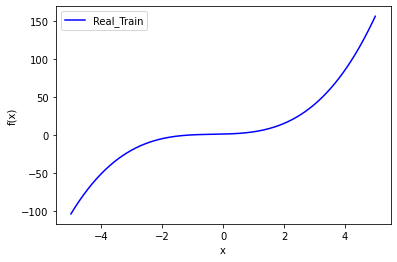

In [16]:
x = torch.linspace(x_l, x_r, No_points).view(-1, 1)
y = f(x)
print(x.shape, y.shape)

plot_1d(x,y)
 

indices = np.arange(No_points)
train_idx, test_idx, _, _ = train_test_split(indices, indices, test_size=0.2, random_state=42)
x_train = x[train_idx]
y_train = y[train_idx]
x_test = x[test_idx]
y_test = y[test_idx]
torch.manual_seed(123)
x_train = x_train.float().to(device)
y_train = y_train.float().to(device)
layers = np.array([1, 50, 50, 20, 50, 50, 1])
model = FPINN(layers)
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=False)
start_time = time.time()



### Training

tensor(2662.9294, grad_fn=<MseLossBackward>)
tensor(217.6864, grad_fn=<MseLossBackward>)
tensor(29.8336, grad_fn=<MseLossBackward>)
tensor(3.2820, grad_fn=<MseLossBackward>)
tensor(0.2981, grad_fn=<MseLossBackward>)
tensor(0.0252, grad_fn=<MseLossBackward>)
tensor(0.0034, grad_fn=<MseLossBackward>)
tensor(0.0015, grad_fn=<MseLossBackward>)
tensor(0.0011, grad_fn=<MseLossBackward>)
tensor(0.0008, grad_fn=<MseLossBackward>)
tensor(7.6294e-06, grad_fn=<MinBackward1>)
tensor(2.1935e-05, grad_fn=<MinBackward1>)


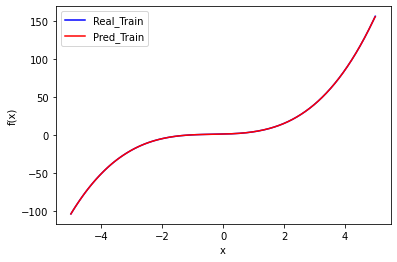

In [17]:
for i in range(iters):
    optimizer.zero_grad()
    yh = model(x_train)
    loss = model.lossPINN(x_train, y_train)
    loss.backward()
    optimizer.step()
    if i % (iters / 10) == 0:
        print(loss)

yf = model(x_train)
yf_test = model(x_test.float().to(device))

_, id_train = torch.sort(x_train.squeeze(1))
_, id_test = torch.sort(x_test.squeeze(1))
x_train_plot = x_train[id_train]
y_train_plot = y_train[id_train]
yf_plot = yf[id_train]
x_test_plot = x_test[id_test]
y_test_plot = y_test[id_test]
yf_test_plot = yf_test[id_test]

plot_1d(x_train_plot,y_train_plot,x_train_plot,yf_plot)
 

print(torch.min(abs(y_train_plot - yf_plot)))
print(torch.min(abs(y_test_plot - yf_test_plot)))

This paper introduces physics-informed neural networks– neural networks that are trained to solve supervised learning tasks while respecting any given laws of physics described by general nonlinear partial differential equations. In this paper, the authors design the neural networks to solve the two main classes of problems: forward solving PDE numerically, inverse problem solving (parameters fixing). When solving these two classes of problems, the authors devise two distinct types of algorithms, namely continuous time and discrete time models. The first type of models forms a new family of data-efficient spatio-temporal function approximators, while the latter type allows the use of arbitrarily accurate implicit Runge–Kutta time stepping schemes with unlimited number of stages. The effectiveness of the proposed framework is demonstrated through a collection of classical problems in fluids, quantum mechanics, reaction–diffusion systems, and the propagation of nonlinear shallow-water waves.

### Contribution

Apply deep learning with a few data to solve physics problems is naive. So to solve the mathematical model with neural network and to make sure the satisfication of physical laws is essential. In this paper, the authors solves the PDEs which are used to describe physical phenomena by applying machine learning and keep physics laws.

### Problem setup

In this work, the authors consider parametrized and nonlinear partial differential equations of the general form:
\begin{align}
u_t + \mathcal{N}[u;\lambda] = 0, \quad x\in \Omega, \quad t\in [0,T]\label{eq1}\tag{1}
\end{align}
where $u(t, x)$ denotes the latent (hidden) solution; Initially I thought this is the output, but since when we apply the neural network to solve the numerical solution for  the above problem, we do not need to know the exact solutions as training data. We only need to know the boundary condition and initial condition, which is quite like we build an exact analytical solution for the above PDE with corresponding right hand side.

$\mathcal{N}[·; \lambda]$ is a nonlinear operator parametrized by $\lambda$, and $\Omega$ is a subset of $\mathbb{R}^{D}$. This setup encapsulates a wide range of problems in mathematical physics including conservation laws, diffusion processes, advection–diffusion–reaction systems, and kinetic equations. As a motivating example, the one dimensional Burgers equation corresponds to the case where $\mathcal{N}[u; \lambda] =\lambda_1 uu_x− \lambda u_{xx} \  \text{and} \ \lambda =(\lambda_1, \lambda_2)$. Here, the subscripts denote partial differentiation in either time or space.

Given noisy measurements of the system, we are interested in the solution of two distinct problems. The first problem is that of inference, filtering and smoothing, or data-driven solutions of partial differential equations: given fixed model parameters $\lambda$ what can be said about the unknown hidden state $u(t, x)$ of the system? The second problem is that of learning, system identification, or data-driven discovery of partial differential equations stating: what are the parameters λthat best describe the observed data?


### Data-driven solutions of partial differential equations


#### Continuous time models

In this section, the authors define the neural network that will be used to solve the partial differential equation (PDE) continuously. The approach is similar to designing an exact solution that satisfies the boundary and initial conditions. However, instead of substituting the PDE into the solution, we constrain the right-hand side of the equation to ensure that it is zero or any given functions. This process is known as the training process.

Define $f(t,x)$ to be given by the left hand side of equation $u_t + \mathcal{N}[u;\lambda] = 0$:
\begin{align}
f:=u_t + \mathcal{N}[u]\label{eqf}\tag{1}
\end{align}

and proceed by approximating $u(t,x)$ by a deep neural network. This assumption along with equation (\ref{eqf}) result in a physics-informed neural network $f(t, x)$.

This network can be derived by applying the chain rule for differentiating compositions of functions using automatic differentiation, and has the same parameters as the network representing $u(t, x)$, albeit with different activation functions due to the action of the differential operator $\mathcal{N}$. The shared parameters between the neural networks $u(t, x)$ and $f(t, x)$ can be learned by minimizing the mean squared error loss

$$MSE = MSE_u + MSE_f$$
where
$$MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u}|u(t^{i}_u,x_u^i)-u^{i}|^2$$
and 
$$MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t^{i}_f,x_f^i)|^2$$

To illustrate the application of Physics-Informed Neural Networks (PINN) for solving partial differential equations, we provide the code implementation for the Poisson equation below:

## Problem Setup

### Poisson equation (2D)

$$-\Delta u =f(x,y)$$

 

### Problem

$$-\Delta u=2\pi^2sin(\pi x)sin(\pi y)$$

### Boundary Conditions:

$$u(-1,y)=0,\  u(1,y) =0, \ u(x,-1)=0,\  u(x,1) =0$$

### Exact solution:

$$u(x)=sin(\pi x)sin(\pi y)$$


So the residual will be:

$$0=\frac{\partial^2u}{\partial x^2}+\frac{\partial^2u}{\partial y^2}+2\pi^2sin(\pi x)sin(\pi y)$$

Note: Remeber that our neural network $NN(x,y)\approx u(x,y)$ so:

$$\frac{\partial^2NN}{\partial x^2}\approx\frac{\partial^2u}{\partial x^2}$$
$$\frac{\partial^2NN}{\partial y^2}\approx\frac{\partial^2u}{\partial y^2}$$

$$f=\frac{\partial^2NN}{\partial x^2}+\frac{\partial^2NN}{\partial y^2}+2\pi^2sin(\pi x)sin(\pi y)\rightarrow 0$$


**Initial Conditions (Dirichlet BC)**
$$u(-1,y)=0,\ u(1,y)=0$$

$$u(x,-1)=0,\ u(x,1)=0$$

Set two functions to describe our boundary conditions:

$$f_{BC_v}(x)=1-|x|,\  x = \pm  1 \ y \in (-1,1)$$
$$f_{BC_h}(x)=1-|y|,\  y = \pm 1 \ x \in (-1,1)$$

In [18]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cpu


### Parameters setting

In [19]:
steps=5000
lr=1e-3
layers = np.array([2,50,50,20,50,50,1]) #5 hidden layers
# To generate new data:
x_l=-1
x_r=1
y_l=-1
y_r=1
total_points=800
#Nu: Number of training points (2 as we onlt have 2 boundaries), # Nf: Number of collocation points (Evaluate PDE)
Nu=1000
Nf=10000

### Functions

In [20]:
def f_BCv(x):
    return 1-torch.abs(x)

def f_BCh(y):
    return 1-torch.abs(y)

def f_real(x,y):
    return torch.sin(np.pi*x)*torch.sin(np.pi*y)

def PDE(x,y):
    return -2*(np.pi**2)*torch.sin(np.pi*x)*torch.sin(np.pi*y)

def plot3D(X,Y,f,title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.numpy(), Y.numpy(), f.numpy(), cmap='jet', edgecolor='none')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')
    ax.set_title(title)
    plt.show()
    
    
def plot_heat(x_l,x_r,y_l,y_r,f,title_colorbar):
    plt.imshow(f.numpy(), cmap='jet', origin='lower', extent=[x_l, x_r, y_l, y_r])
    plt.colorbar(label='f(x, y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title_colorbar)

    plt.show()
    

### Neural Network

In [21]:
class PINN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):

            
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,X):
        if torch.is_tensor(X) != True:         
            X = torch.from_numpy(X)                
        a = X.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,X_BC,f_BC):
        loss_BC=self.loss_function(self.forward(X_BC),f_BC)
        return loss_BC
    #Loss PDE
    def lossPDE(self,X_PDE):
        g=X_PDE.clone()
        g.requires_grad=True #Enable differentiation
        f=self.forward(g)
        f_X=autograd.grad(f,g,grad_outputs=torch.ones_like(f),create_graph=True)[0] #first derivative    
        grad_x =   f_X[:,0]
        grad_y = f_X[:,1]
        f_XX = autograd.grad(grad_x, g, grad_outputs=torch.ones_like(grad_x), create_graph=True)[0][:, 0]
        f_YY = autograd.grad(grad_y, g, grad_outputs=torch.ones_like(grad_y), create_graph=True)[0][:, 1]
        
        solu = 2*np.pi ** 2 *torch.sin(np.pi * g[:, 0:1])*torch.sin(np.pi * g[:, 1:])
        delta_f=f_XX.unsqueeze(1) + f_YY.unsqueeze(1) + solu
        
         
        
        
        return self.loss_function(delta_f,f_hat)
#     + 2*np.pi ** 2 *torch.sin(np.pi * g[:, 0:1])*torch.sin(np.pi * g[:, 1:])
        
    def loss(self,X_BC,f_BC,X_PDE):
        loss_bc=self.lossBC(X_BC,f_BC)
        loss_pde=self.lossPDE(X_PDE)
        return loss_bc+loss_pde
#X_train_Nu,v_train_Nu,X_train_Nf

### Data generation

In [22]:
# Plot the function as a 3D heatmap
x = torch.linspace(x_l,x_r,total_points).view(-1,1) #prepare to NN
y = torch.linspace(y_l,y_r,total_points).view(-1,1) #prepare to NN

X, Y = torch.meshgrid(x.view(-1,), y.view(-1,))
f = f_real(X,Y)
 

In [23]:
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],Y.transpose(1,0).flatten()[:,None]))

v_test=f.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
 
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value 

### Training Data

In [24]:
#Boundary Conditions
#Left Edge 
left_X=torch.hstack((X[0,:][:,None],Y[0,:][:,None])) # First column # The [:,None] is to give it the right dimension
vleft_boundary = f_BCv(left_X[:,0]).unsqueeze(1)



#right Edge
right_X=torch.hstack((X[-1,:][:,None],Y[-1,:][:,None]))
vright_boundary = f_BCv(right_X[:,0]).unsqueeze(1)
 

#Bottom Edge
bottom_X=torch.hstack((X[:,0][:,None],Y[:,0][:,None])) # First row # The [:,None] is to give it the right dimension
vbottom_boundary = f_BCh(bottom_X[:,-1]) .unsqueeze(1)
 

#Top Edge
top_X=torch.hstack((X[:,0][:,None],Y[:,-1][:,None])) # First row # The [:,None] is to give it the right dimension
vtop_boundary = f_BCh(top_X[:,-1]).unsqueeze(1)
 
# #Get all the training data into the same dataset
X_train=torch.vstack([left_X,right_X,bottom_X,top_X])
v_train=torch.vstack([vleft_boundary,vright_boundary,vbottom_boundary,vtop_boundary])
#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
v_train_Nu=v_train[idx,:]
  
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and y
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points
 


### Model training

In [25]:
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
v_train_Nu=v_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function
print(f_hat.shape)

X_test=x_test.float().to(device) # the input dataset (complete)
V_test=v_test.float().to(device) # the real solution 


model = PINN(layers)
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=False)
start_time = time.time()

torch.Size([11000, 1])
PINN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [26]:
model.lossBC(X_train_Nu,v_train_Nu)

tensor(0.0182, grad_fn=<MseLossBackward>)

In [27]:
%%time
for i in range(steps):
     
    loss = model.loss(X_train_Nu,v_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%200==0:
        print(loss)

tensor(88.8535, grad_fn=<AddBackward0>)
tensor(2.1048, grad_fn=<AddBackward0>)
tensor(0.0786, grad_fn=<AddBackward0>)
tensor(0.0310, grad_fn=<AddBackward0>)
tensor(0.0240, grad_fn=<AddBackward0>)
tensor(0.0203, grad_fn=<AddBackward0>)
tensor(0.0176, grad_fn=<AddBackward0>)
tensor(0.0156, grad_fn=<AddBackward0>)
tensor(0.0139, grad_fn=<AddBackward0>)
tensor(0.0151, grad_fn=<AddBackward0>)
tensor(0.0118, grad_fn=<AddBackward0>)
tensor(0.0121, grad_fn=<AddBackward0>)
tensor(0.0098, grad_fn=<AddBackward0>)
tensor(0.0090, grad_fn=<AddBackward0>)
tensor(0.0085, grad_fn=<AddBackward0>)
tensor(0.0085, grad_fn=<AddBackward0>)
tensor(0.0069, grad_fn=<AddBackward0>)
tensor(0.0129, grad_fn=<AddBackward0>)
tensor(0.0090, grad_fn=<AddBackward0>)
tensor(0.0120, grad_fn=<AddBackward0>)
tensor(0.0101, grad_fn=<AddBackward0>)
tensor(0.0047, grad_fn=<AddBackward0>)
tensor(0.0084, grad_fn=<AddBackward0>)
tensor(0.0090, grad_fn=<AddBackward0>)
tensor(0.0036, grad_fn=<AddBackward0>)
tensor(0.0063, grad_fn=<

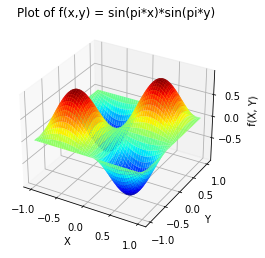

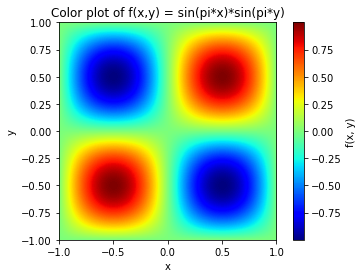

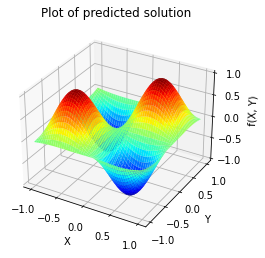

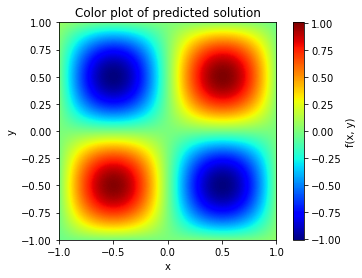

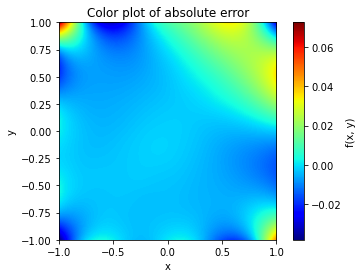

In [28]:
y_predict = model(x_test).detach()
 
reshaped_f = torch.reshape(y_predict, X.shape).transpose(1,0)

title = 'Plot of f(x,y) = sin(pi*x)*sin(pi*y)'
plot3D(X,Y,f,title)
title_colorbar = 'Color plot of f(x,y) = sin(pi*x)*sin(pi*y)'
plot_heat(x_l,x_r,y_l,y_r,f,title_colorbar)

title = 'Plot of predicted solution'
plot3D(X,Y,reshaped_f,title)
title_colorbar = 'Color plot of predicted solution'
plot_heat(x_l,x_r,y_l,y_r,reshaped_f,title_colorbar)

title_colorbar = 'Color plot of absolute error' 
plot_heat(x_l,x_r,y_l,y_r,reshaped_f-f,title_colorbar) 

### Data-driven discovery of partial differential equations

#### Continuous time models

In this section, the authors define the neural network that will be used to solve the inverse problems of partial differential equations which have parameters in the PDE:
$$u_t + \mathcal{N}(u,\lambda) = 0$$
Similar to the above Data-driven solutions of partial differential equations, we can define the neural network as
$$f(x,t) := u_t + \mathcal{N}(u,\lambda)$$
The parameters of the differential operator $\lambda$ turn into parameters of the physics-informed neural network.To illustrate the application of Physics-Informed Neural Networks (PINN) for solving partial differential equations, we provide the code implementation for the Poisson equation below:

## Problem Setup

### Burgers equation

$$\frac{\partial u}{\partial t}  + \lambda_1 u\frac{\partial u}{\partial x} - \lambda_2 \frac{\partial^2 u}{\partial x^2} =0$$
By using training data selected from the initial, boundary, and inner domain data, we can determine the parameters $\lambda_1$ and $\lambda_2$ in the Burgers equation. It is important to emphasize that our objective in this problem is to solve for the parameters in the Burgers equation, rather than obtaining a numerical solution of the equation itself. The training data can be chosen from the inner domain, and there is no need to identify specific initial and boundary training data or collocation points. To tackle this problem, we can treat the parameters of the Burgers equation as the parameters of the neural network, denoted as $f(\theta,x,t) := \frac{\partial u_{NN}(\theta,x,t)}{\partial t} + \lambda_1 u_{NN}(\theta,x,t) \frac{\partial u_{NN}(\theta,x,t)}{\partial x} - \lambda_2 \frac{\partial^2 u_{NN}(\theta,x,t)}{\partial x^2}$, where $\theta$ is the weight of the neural network. The loss function is the same as above:
$$MSE = MSE_u + MSE_f$$
where
$$MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u}|u(t^{i}_u,x_u^i)-u^{i}|^2$$
and 
$$MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t^{i}_f,x_f^i)|^2$$

## Libraries

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from collections import OrderedDict

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling

import scipy.io
from scipy.interpolate import griddata
import sys
 

#Set default dtype to float32
torch.set_default_dtype(torch.float)

np.random.seed(1234)



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


## Data Preparation

In [2]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

## Physics-informed Neural Networks

In [3]:
# the deep neural network
class Solu_NN(torch.nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
    
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with Recommended gain value?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,X):
         
        a = X.float()


        for i in range(len(layers)-2):

            z = self.linears[i](a)

            a = self.activation(z)

        out = self.linears[-1](a)


        return out

In [7]:
# the physics-guided neural network
class PINN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device)
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.u_nn = Solu_NN(layers).to(device)
        self.u_nn.register_parameter('lambda_1', self.lambda_1)
        self.u_nn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.u_nn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.u_nn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, lambda0_1: %.5f, lambda0_2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
             
        return loss
    
    def train(self, nIter):
        self.u_nn.train()
        
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.u_nn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Training on Non-noisy Data

In [9]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PINN(X_u_train, u_train, layers, lb, ub)
model.train(0)

Loss: 1.867064e-02, lambda0_1: 0.38620, lambda0_2: 0.00237
Loss: 6.144837e-03, lambda0_1: 0.69146, lambda0_2: 0.00300
Loss: 1.766257e-03, lambda0_1: 0.89200, lambda0_2: 0.00364
Loss: 6.131161e-04, lambda0_1: 0.96284, lambda0_2: 0.00401
Loss: 3.053265e-04, lambda0_1: 0.98332, lambda0_2: 0.00399
Loss: 1.743129e-04, lambda0_1: 0.98855, lambda0_2: 0.00378
Loss: 1.075826e-04, lambda0_1: 0.99078, lambda0_2: 0.00354
Loss: 8.147092e-05, lambda0_1: 0.99546, lambda0_2: 0.00343
Loss: 6.227753e-05, lambda0_1: 0.99702, lambda0_2: 0.00332
Loss: 4.963260e-05, lambda0_1: 0.99721, lambda0_2: 0.00322
Loss: 3.998382e-05, lambda0_1: 0.99656, lambda0_2: 0.00318
Loss: 3.487516e-05, lambda0_1: 0.99601, lambda0_2: 0.00315
Loss: 3.043714e-05, lambda0_1: 0.99674, lambda0_2: 0.00315
Loss: 2.669462e-05, lambda0_1: 0.99901, lambda0_2: 0.00314
Loss: 2.363285e-05, lambda0_1: 0.99713, lambda0_2: 0.00313
Loss: 2.063323e-05, lambda0_1: 0.99765, lambda0_2: 0.00315
Loss: 1.821003e-05, lambda0_1: 0.99853, lambda0_2: 0.003

In [10]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 7.565182e-04
Error l1: 0.00526%
Error l2: 0.09619%


In [11]:
noise = 0.01    

# create training set
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
model = PINN(X_u_train, u_train, layers, lb, ub)
model.train(0)            

Loss: 1.763073e-02, lambda0_1: 0.35650, lambda0_2: 0.00212
Loss: 5.268118e-03, lambda0_1: 0.73358, lambda0_2: 0.00253
Loss: 2.120698e-03, lambda0_1: 0.88826, lambda0_2: 0.00289
Loss: 9.209848e-04, lambda0_1: 0.94204, lambda0_2: 0.00288
Loss: 5.108174e-04, lambda0_1: 0.95425, lambda0_2: 0.00290
Loss: 3.502066e-04, lambda0_1: 0.97779, lambda0_2: 0.00301
Loss: 2.545694e-04, lambda0_1: 0.98976, lambda0_2: 0.00309
Loss: 1.943522e-04, lambda0_1: 0.98964, lambda0_2: 0.00313
Loss: 1.470200e-04, lambda0_1: 0.98585, lambda0_2: 0.00313
Loss: 1.173363e-04, lambda0_1: 0.99064, lambda0_2: 0.00317
Loss: 9.914080e-05, lambda0_1: 0.99789, lambda0_2: 0.00320
Loss: 8.791353e-05, lambda0_1: 0.99581, lambda0_2: 0.00320
Loss: 8.275727e-05, lambda0_1: 0.99861, lambda0_2: 0.00319
Loss: 7.791244e-05, lambda0_1: 0.99636, lambda0_2: 0.00317
Loss: 7.309886e-05, lambda0_1: 0.99463, lambda0_2: 0.00316
Loss: 6.888982e-05, lambda0_1: 0.99651, lambda0_2: 0.00315
Loss: 6.608551e-05, lambda0_1: 0.99820, lambda0_2: 0.003

In [12]:
# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda_2_noisy))  

Error u: 7.565182e-04
Error l1: 0.09127%
Error l2: 0.79148%


## Plots

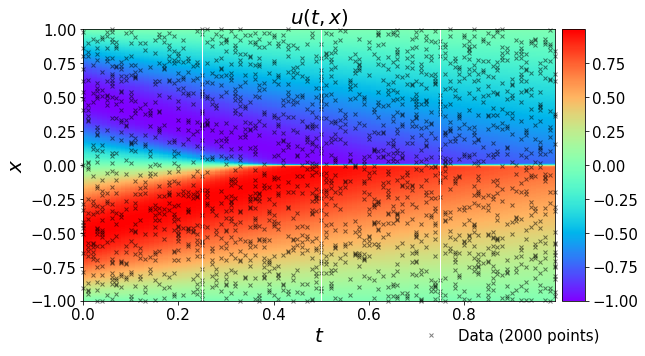

In [13]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

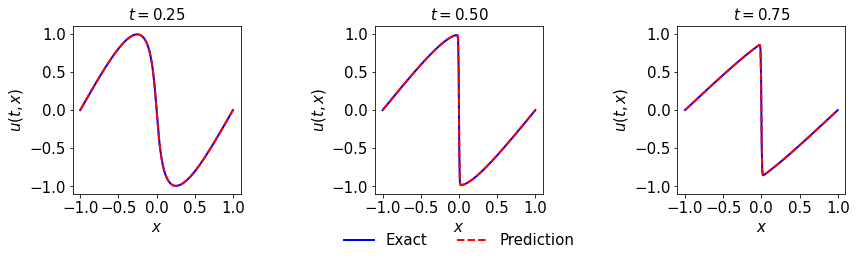

In [14]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()